#Загружаем необходимые библиотеки и зависимости

In [0]:
!pip install pytorch_transformers
!pip install transformers 

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from torch.optim import SGD, Adam
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import pandas as pd
import io
import random
import re
import string
import time
import datetime
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output            #Улаляем все лишние выводы. Если естб ошибки, то все остановиться раньше
clear_output()

SEED = 42

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla K80


# Загружаем подготовленные данные и работаем с ними.

<pre>
Данные должны быть формата CSV. Должно быть 3 столбца: 
sentiment - эмоциональная окраска твита, целевая метка. 
            0 - positive 
            1 - neutral 
            2 - negative 
tweet - текст твита, обработанный или нет 
dataset - из какого датасета взят твит 
</pre>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('./drive/My Drive/Twitter sentiment analysis/Data/Concat datasets /en_de_fr.csv')
data

,sentiment,tweet,dataset,language
0,2,#ClimateChange a Non-Issue in #GOPDebate / Pri...,gop,en
1,2,@united I'm desperately trying to understand h...,airlines,en
2,2,RT @BrianZahnd: My Native American friends get...,gop,en
3,0,@SouthwestAir Got help from a nice lady on the...,airlines,en
4,1,@USAirways if there are empty first class seat...,airlines,en
...,...,...,...,...
31412,1,Le métro arrêté une minute à midi à #Marseille...,Charlie,fr
31413,1,#CharlieHebdo Plus de 5 millions de tweets pou...,Charlie,fr
31414,1,#Google a changé sa page d&#39;accueil ! #JeSu...,Charlie,fr
31415,1,&quot;Il y a 3 sources de renseignement : tech...,Charlie,fr


Отобразим распределение наших данных

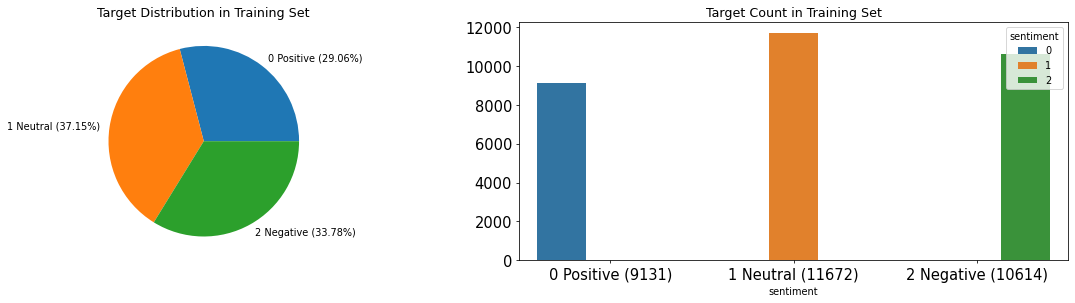

In [0]:
def plot_label_distribution(data):
    percentage = data.groupby('sentiment').size() / len(data) * 100
    amount = data.groupby('sentiment').size()

    fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=70)
    plt.tight_layout()

    data.groupby('sentiment').count()['tweet'].plot(kind='pie', ax=axes[0], labels=['0 Positive ({0:.2f}%)'.format(percentage[0]), '1 Neutral ({0:.2f}%)'.format(percentage[1]), '2 Negative ({0:.2f}%)'.format(percentage[2])])
    sns.countplot(x=data['sentiment'], hue=data['sentiment'], ax=axes[1])

    axes[0].set_ylabel('')
    axes[1].set_ylabel('')
    axes[1].set_xticklabels(['0 Positive ({})'.format(amount[0]), '1 Neutral ({})'.format(amount[1]), '2 Negative ({})'.format(amount[2])])
    axes[0].tick_params(axis='x', labelsize=15)
    axes[0].tick_params(axis='y', labelsize=15)
    axes[1].tick_params(axis='x', labelsize=15)
    axes[1].tick_params(axis='y', labelsize=15)

    axes[0].set_title('Target Distribution in Training Set', fontsize=13)
    axes[1].set_title('Target Count in Training Set', fontsize=13)

    plt.show()

plot_label_distribution(data)

In [0]:
data.groupby('language').aggregate({'sentiment' : 'count'})

,sentiment
language,
de,8170
en,14419
fr,8828


## Отчистка данных

In [0]:
def clean_text(tweet):    
    # #Ссылки
    tweet = re.sub(r'\s*(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*\S*', '', tweet, flags=re.MULTILINE)      #убирает все ссылки кроме pic.twitter.com/
    tweet = re.sub(r'(pic.twitter.com\/)(\w)*(\S)*(\s)*', '', tweet, flags=re.MULTILINE)                                                                        #убирает все pic.twitter.com/
    tweet = re.sub(r'@(\w)*(\S)*(\s)*', '', tweet, flags=re.MULTILINE)                                                                                          #убирает все обращения


    # Эмоджи
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)

    #Удаление спецсимволов
    tweet = re.sub(r"\n", " ", tweet)
    tweet = re.sub(r"\t", " ", tweet)
    tweet = re.sub(r"\n", " ", tweet)
    
    # #slang
    # slang = {"whassup": "what is up", "whatser": "what is her", "whatsiz": "what is his", "gimme": "give me", "lemme": "let me", "coulda": "could have", "mighta": "might have", "musta": "must have", "shoulda": "should have", "woulda": "would have", "gonna": "going to", "gotta": "got to", "hafta": "have to", "hasta": "has to", "oughta": "ought to", "wanna": "want to", "donno": "do not know", "dunno": "do not know", "jeet": "did you eat", "jev": "did you have", "jever": "did you ever", "betcha": "bet you", "doncha": "don not you", "getcha": "get you", "gotcha": "got you", "howarya": "how are you", "howdya": "how do you", "howjya": "how did you", "howujya": "how would you", "jya": "did you", "whaddaya": "what do you", "wancha": "want you", "whajya": "what did you", "whenjya": "when did you", "wherjya": "where did you", "whojya": "who did you", "woujya": "would you", "frunna": "front of", "kinda": "kind of", "kindsa": "kinds of", "lotsa": "lots of", "lotta": "lot of", "outta": "out of", "sorta": "sort of", "typa": "type of", "r": "are", "ur": "you are", "u": "you", "$": " dollar ", "€": " euro ", "4ao": "for adults only", "a.m": "before midday", "a3": "anytime anywhere anyplace", "aamof": "as a matter of fact", "acct": "account", "adih": "another day in hell", "afaic": "as far as i’m concerned", "afaict": "as far as i can tell", "afaik": "as far as i know", "afair": "as far as i remember", "afk": "away from keyboard", "app": "application", "approx": "approximately", "apps": "applications", "asap": "as soon as possible", "asl": "age, sex, location", "atk": "at the keyboard", "ave.": "avenue", "aymm": "are you my mother", "ayor": "at your own risk", "b&b": "bed and breakfast", "b+b": "bed and breakfast", "b.c": "before christ", "b2b": "business to business", "b2c": "business to customer", "b4": "before", "b4n": "bye for now", "b@u": "back at you", "bae": "before anyone else", "bak": "back at keyboard", "bbbg": "bye bye be good", "bbc": "british broadcasting corporation", "bbias": "be back in a second", "bbl": "be back later", "bbs": "be back soon", "be4": "before", "bfn": "bye for now", "blvd": "boulevard", "bout": "about", "brb": "be right back", "bros": "brothers", "brt": "be right there", "bsaaw": "big smile and a wink", "btw": "by the way", "bwl": "bursting with laughter", "c/o": "care of", "cet": "central european time", "cf": "compare", "cia": "central intelligence agency", "csl": "cannot stop laughing", "cu": "see you", "cul8r": "see you later", "cv": "curriculum vitae", "cwot": "complete waste of time", "cya": "see you", "cyt": "see you tomorrow", "dae": "does anyone else", "dbmib": "do not bother me i am busy", "diy": "do it yourself", "dm": "direct message", "dwh": "during work hours", "e123": "easy as one two three", "eet": "eastern european time", "eg": "example", "embm": "early morning business meeting", "encl": "enclosed", "encl.": "enclosed", "etc": "and so on", "faq": "frequently asked questions", "fawc": "for anyone who cares", "fb": "facebook", "fc": "fingers crossed", "fig": "figure", "fimh": "forever in my heart", "ft.": "feet", "ft": "featuring", "ftl": "for the loss", "ftw": "for the win", "fwiw": "for what it is worth", "fyi": "for your information", "g9": "genius", "gahoy": "get a hold of yourself", "gal": "get a life", "gcse": "general certificate of secondary education", "gfn": "gone for now", "gg": "good game", "gl": "good luck", "glhf": "good luck have fun", "gmt": "greenwich mean time", "gmta": "great minds think alike", "gn": "good night", "g.o.a.t": "greatest of all time", "goat": "greatest of all time", "goi": "get over it", "gps": "global positioning system", "gr8": "great", "gratz": "congratulations", "gyal": "girl", "h&c": "hot and cold", "hp": "horsepower", "hr": "hour", "hrh": "his royal highness", "ht": "height", "ibrb": "i will be right back", "ic": "i see", "icq": "i seek you", "icymi": "in case you missed it", "idc": "i don not care", "idgadf": "i do not give a damn fuck", "idgaf": "i do not give a fuck", "idk": "i do not know", "ie": "that is", "i.e": "that is", "ifyp": "i feel your pain", "IG": "instagram", "iirc": "if i remember correctly", "ilu": "i love you", "ily": "i love you", "imho": "in my humble opinion", "imo": "in my opinion", "imu": "i miss you", "iow": "in other words", "irl": "in real life", "j4f": "just for fun", "jic": "just in case", "jk": "just kidding", "jsyk": "just so you know", "l8r": "later", "lb": "pound", "lbs": "pounds", "ldr": "long distance relationship", "lmao": "laugh my ass off", "lmfao": "laugh my fucking ass off", "lol": "laughing out loud", "ltd": "limited", "ltns": "long time no see", "m8": "mate", "mf": "motherfucker", "mfs": "motherfuckers", "mfw": "my face when", "mofo": "motherfucker", "mph": "miles per hour", "mr": "mister", "mrw": "my reaction when", "ms": "miss", "mte": "my thoughts exactly", "nagi": "not a good idea", "nbc": "national broadcasting company", "nbd": "not big deal", "nfs": "not for sale", "ngl": "not going to lie", "nhs": "national health service", "nrn": "no reply necessary", "nsfl": "not safe for life", "nsfw": "not safe for work", "nth": "nice to have", "nvr": "never", "nyc": "new york city", "oc": "original content", "og": "original", "ohp": "overhead projector", "oic": "oh i see", "omdb": "over my dead body", "omg": "oh my god", "omw": "on my way", "p.a": "per annum", "p.m": "after midday", "pm": "prime minister", "poc": "people of color", "pov": "point of view", "pp": "pages", "ppl": "people", "prw": "parents are watching", "ps": "postscript", "pt": "point", "ptb": "please text back", "pto": "please turn over", "qpsa": "what happens", "ratchet": "rude", "rbtl": "read between the lines", "rlrt": "real life retweet", "rofl": "rolling on the floor laughing", "roflol": "rolling on the floor laughing out loud", "rotflmao": "rolling on the floor laughing my ass off", "rt": "retweet", "ruok": "are you ok", "sfw": "safe for work", "sk8": "skate", "smh": "shaking my head", "sq": "square", "srsly": "seriously", "ssdd": "same stuff different day", "tbh": "to be honest", "tbs": "tablespooful", "tbsp": "tablespooful", "tfw": "that feeling when", "thks": "thank you", "tho": "though", "thx": "thank you", "tia": "thanks in advance", "til": "today i learned", "tl;dr": "too long i did not read", "tldr": "too long did not read", "tmb": "tweet me back", "tntl": "trying not to laugh", "ttyl": "talk to you later", "u2": "you too", "u4e": "yours for ever", "utc": "coordinated universal time", "w/": "with", "w/o": "without", "w8": "wait", "wassup": "what is up", "wb": "welcome back", "wtf": "what the fuck", "wtg": "way to go", "wtpa": "where the party at", "wuf": "where are you from", "wuzup": "what is up", "wywh": "wish you were here", "yd": "yard", "ygtr": "you got that right", "ynk": "you never know", "zzz": "tired", "qq": "crying", "ianal": "i am not a lawyer", "aka": "also known as"}
    # tmp_text = []                                                   # временное хранилище нашего предложения (будем добавлять слова по одному)
    # for word in tweet.split():                                      # итерируемся по каждому слову в тексте и каждому ключу в словаре сленга
        
    #     tmp_main = word[0:-1]                                       # split разбивает слова так, что в конце слова может оказаться пунктуация
    #     tmp_main += re.sub(r'\W', '', word[-1])                     # проверяем, нет ли пунктуации в конце слова, если нет, то добавляем последнюю букву к слову
    #     tmp = tmp_main                                              # будем сравнивать tmp, которое может измениться с изначальным tmp_main чтобы не делать лишние проходы по словарю
        
    #     for key in slang:
    #         if tmp_main == tmp:
    #             if tmp == key:
    #                 tmp = slang[key] 
    #     tmp_text.append(tmp)

    return tweet

In [0]:
df = data
sentences = df['tweet'].astype(str)

sentences = ["[CLS] " + clean_text(sentence) + " [SEP]" for sentence in sentences]  
labels = []

for item in df['sentiment']:
  labels.append([item])

In [0]:
for i in range(10):
    key = random.randint(0, 7000)
    print(df.tweet.iloc[key])
    print(sentences[key])
    print(labels[key])
    print('')

‘Fat pigs, dogs, slobs and disgusting animals’: Female victims of Trump’s sexist insults brought up in #GOPdebate  http://t.co/RAs5SFCNig
[CLS] ‘Fat pigs, dogs, slobs and disgusting animals’: Female victims of Trump’s sexist insults brought up in #GOPdebate [SEP]
[2]

@JetBlue I had a SJC to JFK departing 10:55pm tonight. I have to now change my whole schedule. Can we get a sort of refund for this?
[CLS] I had a SJC to JFK departing 10:55pm tonight. I have to now change my whole schedule. Can we get a sort of refund for this? [SEP]
[2]

RT @simplyj_6&#10;&quot;@FeministArmy: Liberal &amp; proud of it!! RT if you agree please!! pic.twitter.com/G9k5rHAQN8&quot; #ferguson @Opferguson #p2
[CLS] RT Liberal &amp; proud of it!! RT if you agree please!! #ferguson #p2 [SEP]
[0]

RT @TheAbridgedZach: The 3 Most and Least Libertarian Moments from Last Night's #GOPDebate. (Spoiler: "Most" was slim pickin'): https://t.c…
[CLS] RT The 3 Most and Least Libertarian Moments from Last Night's #GOPDebate

## Сделаем отложенную выборку 

In [0]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.20, random_state=SEED, stratify=df['dataset'])

# Создание модели

In [0]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased") 
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

100%|██████████| 995526/995526 [00:01<00:00, 908382.40B/s]


In [0]:
print (train_sentences[1], '\n')
print (tokenized_texts[1])
print (labels[1])

[CLS] RT #geziparkı is with you!&#10;#MikeBrown #HandsUpDontShoot #Ferguson #JusticeForMikeBrown&#10;#Turkey #istanbul [SEP] 

['[CLS]', 'RT', '#', 'ge', '##zi', '##park', '##ı', 'is', 'with', 'you', '!', '&', '#', '10', ';', '#', 'Mike', '##B', '##row', '##n', '#', 'Hands', '##U', '##p', '##D', '##ont', '##S', '##ho', '##ot', '#', 'Ferguson', '#', 'Justice', '##F', '##or', '##M', '##ike', '##B', '##row', '##n', '&', '#', '10', ';', '#', 'Turkey', '#', 'ista', '##n', '##bul', '[SEP]']
[2]


Возьмем 97-ой квантиль от колличества токенов в предложении

In [0]:
print(pd.Series(tokenized_texts).map(lambda x: len(x)).quantile(0.99))

86.0


In [0]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,               #токены предложений
    maxlen=110,               #максимальное колличество токенов
    dtype="long",
    truncating="post",       #обрезать после
    padding="post"           #добавить паддинг после 
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Разобьем нашу выборку на обучение и валидацию

In [0]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=SEED,
    test_size=0.2,
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=SEED,
    test_size=0.2,
)

Переведем наши данные в тензоры

In [0]:
train_inputs = torch.LongTensor(train_inputs)
train_labels = torch.LongTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.LongTensor(validation_inputs)
validation_labels = torch.LongTensor(validation_labels)
validation_masks = torch.LongTensor(validation_masks)

Разобьем данные на батчи, чтобы загружать данные в памят видеокарты пачками

In [0]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=32
)

In [0]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    shuffle=True,
    batch_size=32
)

Загрузим модель

In [0]:
#Download the pretrained model
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)



100%|██████████| 714314041/714314041 [01:00<00:00, 11744232.74B/s]


In [0]:
# D_in - размерность входа (768 у BERT);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 768, 2000, 3

# Use the nn package to define our model and loss function.
classifier = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.PReLU(),
    torch.nn.Linear(H, H),
    torch.nn.Dropout(0.1),
    torch.nn.PReLU(),
    torch.nn.Linear(H, D_out),
)

model.classifier = classifier

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [0]:
# layers_to_unfreeze = 4 + 16 * 5

params = list(model.named_parameters())
# for p in params[:-layers_to_unfreeze]:    
#     p[1].requires_grad = False

for p in params[:]:    
    print("{:<55} {:>12}".format(p[0], str(p[1].requires_grad)))

bert.embeddings.word_embeddings.weight                          True
bert.embeddings.position_embeddings.weight                      True
bert.embeddings.token_type_embeddings.weight                    True
bert.embeddings.LayerNorm.weight                                True
bert.embeddings.LayerNorm.bias                                  True
bert.encoder.layer.0.attention.self.query.weight                True
bert.encoder.layer.0.attention.self.query.bias                  True
bert.encoder.layer.0.attention.self.key.weight                  True
bert.encoder.layer.0.attention.self.key.bias                    True
bert.encoder.layer.0.attention.self.value.weight                True
bert.encoder.layer.0.attention.self.value.bias                  True
bert.encoder.layer.0.attention.output.dense.weight              True
bert.encoder.layer.0.attention.output.dense.bias                True
bert.encoder.layer.0.attention.output.LayerNorm.weight          True
bert.encoder.layer.0.attention.out

In [0]:
model.classifier

Sequential(
  (0): Linear(in_features=768, out_features=2000, bias=True)
  (1): PReLU(num_parameters=1)
  (2): Linear(in_features=2000, out_features=2000, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): PReLU(num_parameters=1)
  (5): Linear(in_features=2000, out_features=3, bias=True)
)

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 3.5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                #   weight_decay=1e-2
                )


epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Helper function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Training loop

In [0]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = SEED

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Will save the best model
best_score = 0
best_epoch = 0

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    #save model if the best
    if (1/ avg_val_loss) > best_score:
        best_params = model.state_dict()
        best_score = 1 / avg_val_loss
        best_epoch = epoch_i 

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

model.load_state_dict(best_params)


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    629.    Elapsed: 0:00:49.
  Batch    80  of    629.    Elapsed: 0:01:38.
  Batch   120  of    629.    Elapsed: 0:02:28.
  Batch   160  of    629.    Elapsed: 0:03:17.
  Batch   200  of    629.    Elapsed: 0:04:06.
  Batch   240  of    629.    Elapsed: 0:04:56.
  Batch   280  of    629.    Elapsed: 0:05:45.
  Batch   320  of    629.    Elapsed: 0:06:35.
  Batch   360  of    629.    Elapsed: 0:07:25.
  Batch   400  of    629.    Elapsed: 0:08:14.
  Batch   440  of    629.    Elapsed: 0:09:04.
  Batch   480  of    629.    Elapsed: 0:09:53.
  Batch   520  of    629.    Elapsed: 0:10:43.
  Batch   560  of    629.    Elapsed: 0:11:32.
  Batch   600  of    629.    Elapsed: 0:12:22.

  Average training loss: 0.79
  Training epcoh took: 0:12:57

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.67
  Validation took: 0:01:05

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    629.    Elapsed: 0:00:50.
  Batch  

<All keys matched successfully>

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

#Lable best model
df_stats['Best Model'] = False
df_stats['Best Model'][best_epoch] = True

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time,Best Model
epoch,,,,,,
1,0.79,0.67,0.72,0:12:57,0:01:05,False
2,0.56,0.64,0.74,0:12:56,0:01:04,True
3,0.38,0.73,0.74,0:12:54,0:01:04,False


НУЖНО БООООЛЬШЕ ГРАФИКОВ

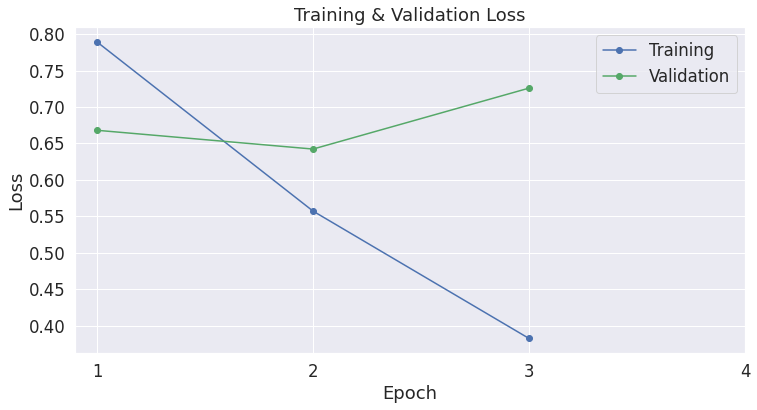

In [0]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#Оценка качества на отложенной выборке

In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=130,
    dtype="long",
    truncating="post",
    padding="post"
)

In [0]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids).to(torch.int64)
prediction_masks = torch.tensor(attention_masks).to(torch.int64)
prediction_labels = torch.tensor(test_gt).to(torch.int64)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=64
)

In [0]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [0]:
print("Метрики качества на отложенной выборке")

print("Accuracy: {0:.4f}".format(
    accuracy_score(test_labels, test_preds)
))

print("Precision: {0:.4f}".format(
    precision_score(test_labels, test_preds, average='macro')
))

print("Recall {0:.4f}".format(
    recall_score(test_labels, test_preds, average='macro')
))

print("F1 score: {0:.4f}".format(
    f1_score(test_labels, test_preds, average='macro')
))

Метрики качества на отложенной выборке
Accuracy: 0.7406
Precision: 0.7423
Recall 0.7410
F1 score: 0.7416


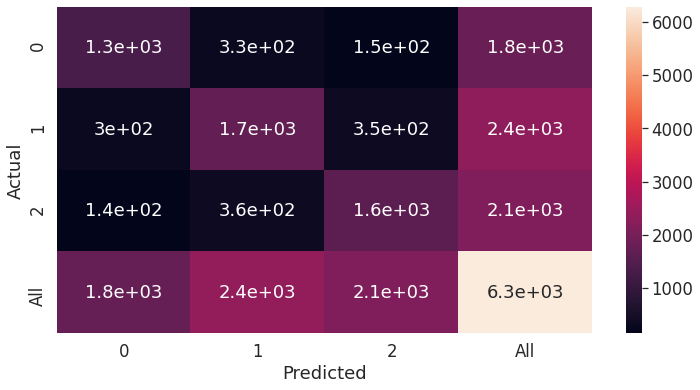

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

data = {'y_Actual':    test_labels,
        'y_Predicted': test_preds
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)


sn.heatmap(confusion_matrix, annot=True)
